In [6]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
import cv2
%matplotlib inline
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Getting the Images

In [7]:
imageDir = "test_images/"
imageFiles = os.listdir(imageDir)
imageList = []
for i in range(0, len(imageFiles)):
    imageList.append(mpimg.imread(imageDir + imageFiles[i]))
print(imageFiles)

['solidWhiteCurve.jpg', 'solidWhiteRight.jpg', 'solidYellowCurve.jpg', 'solidYellowCurve2.jpg', 'solidYellowLeft.jpg', 'whiteCarLaneSwitch.jpg']


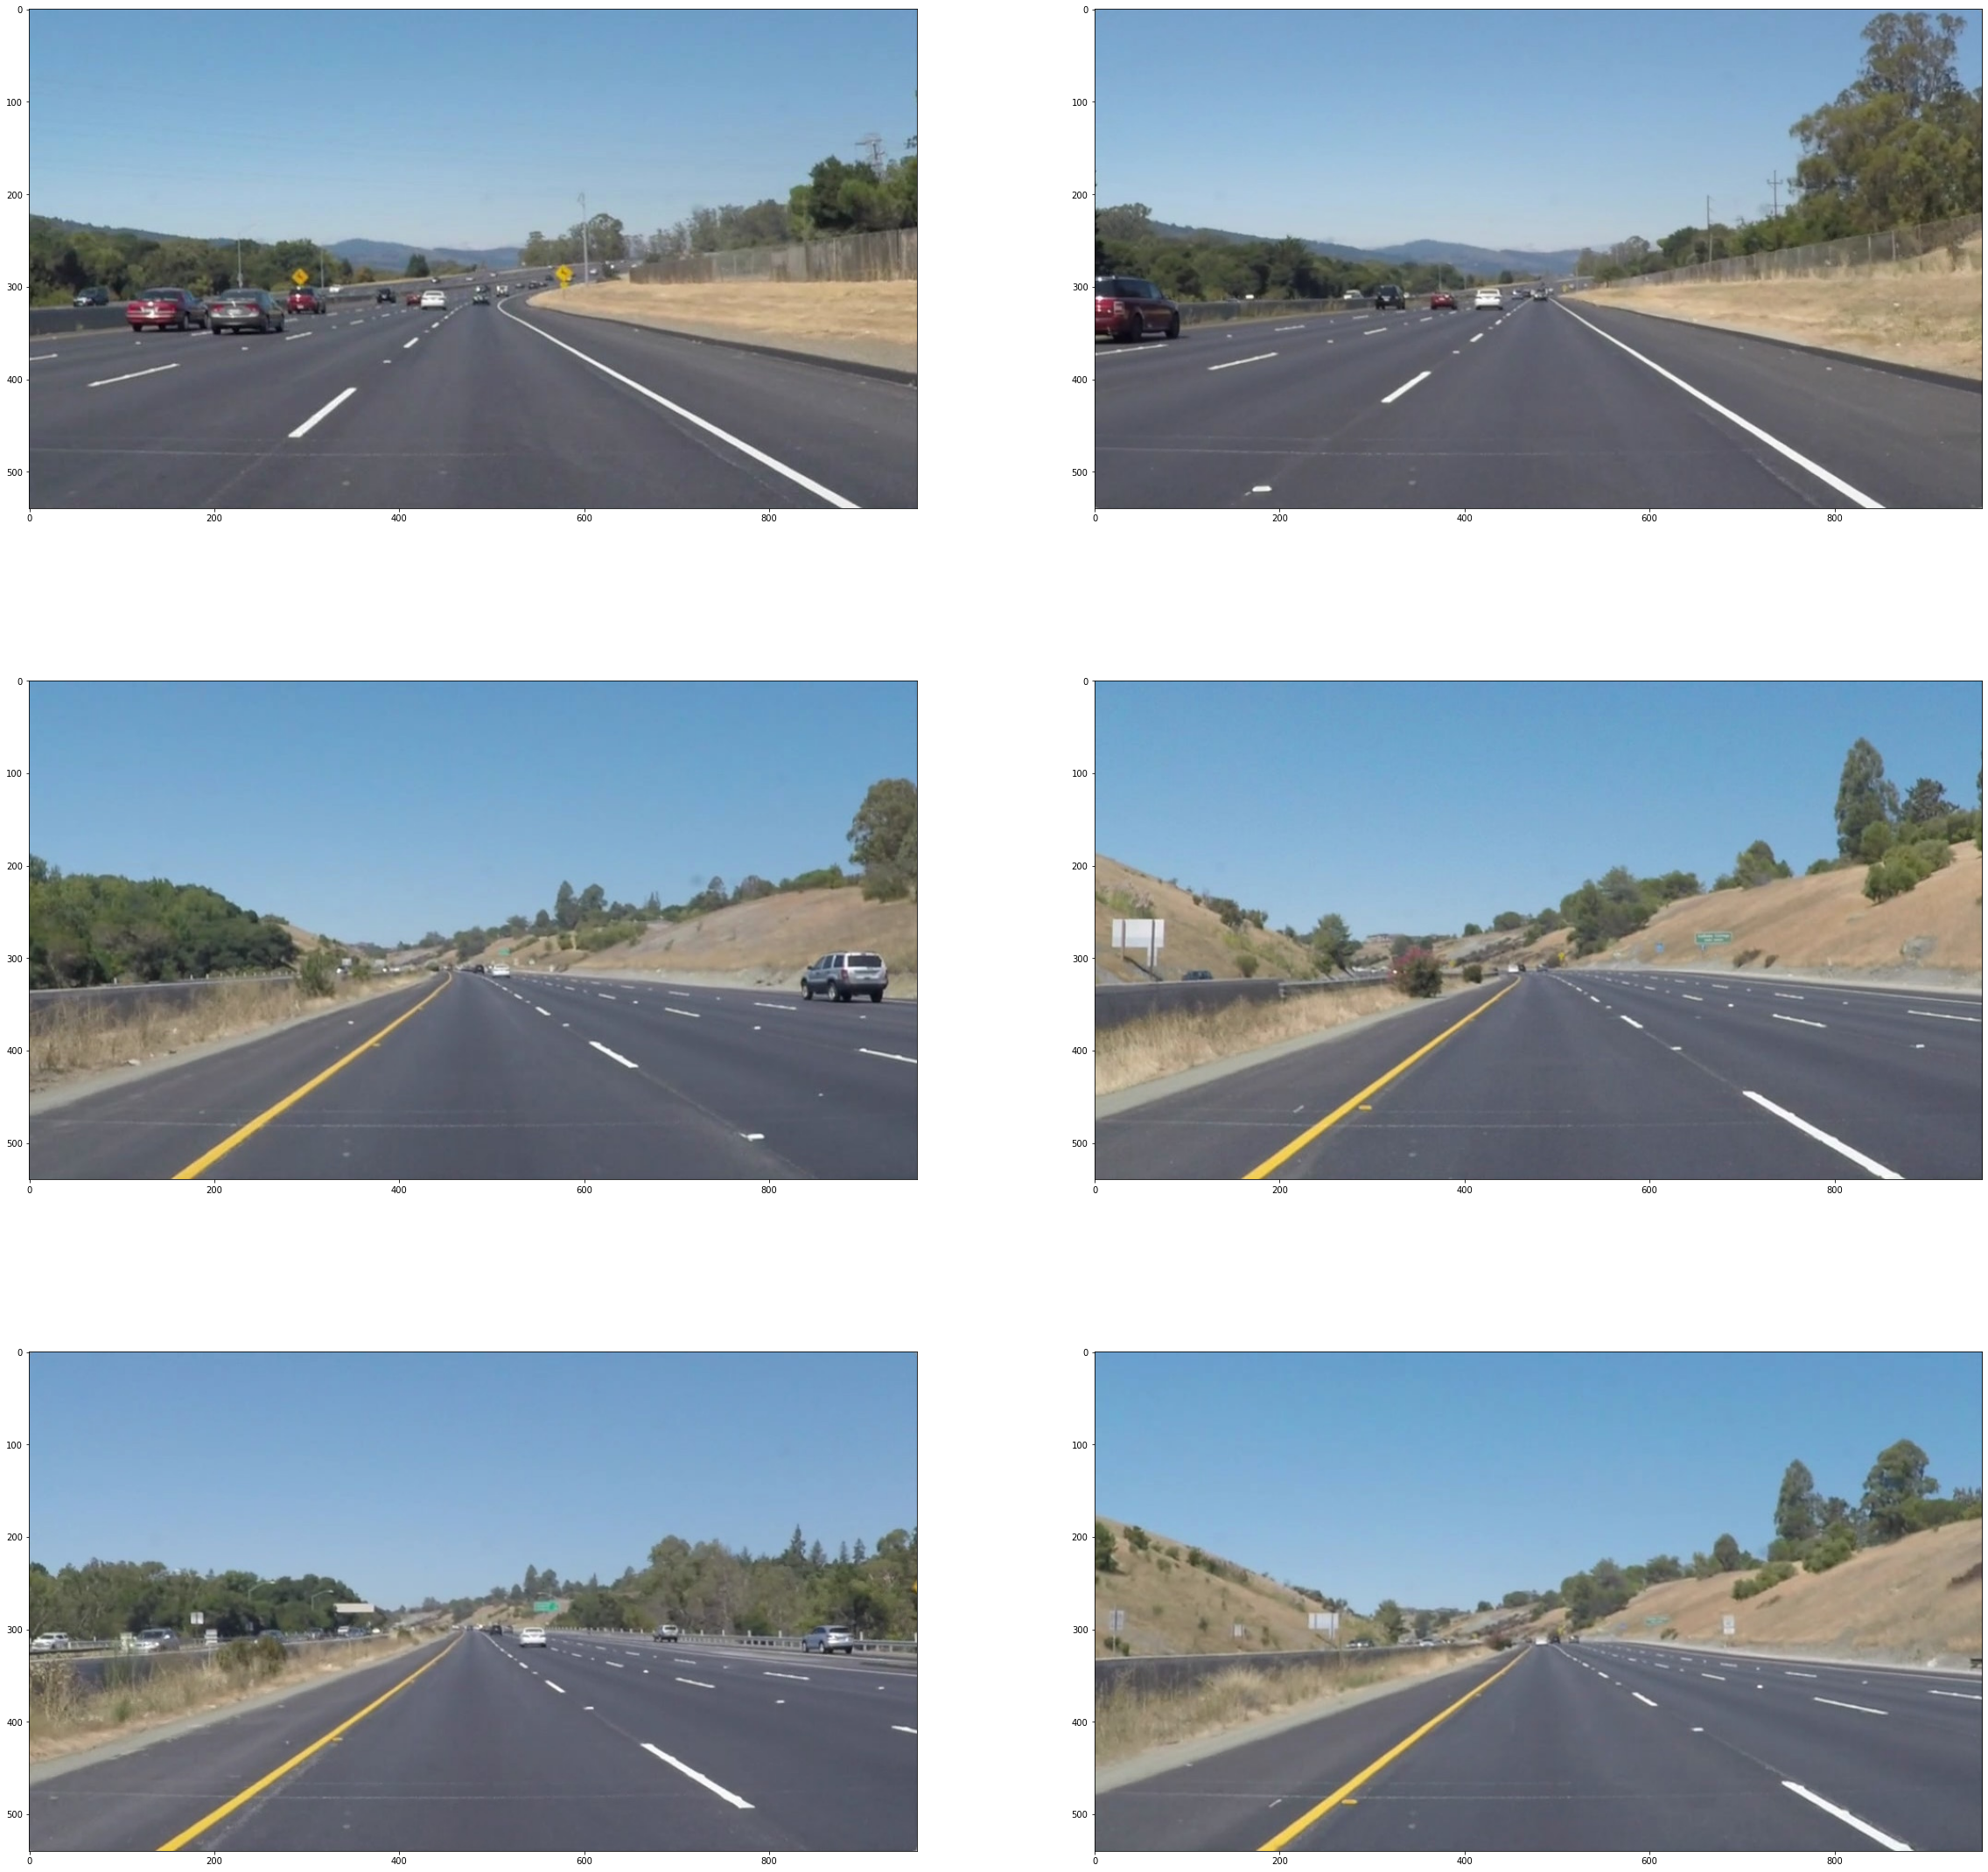

In [8]:
def display_images(images, cmap = None):
    plt.figure(figsize =(40,40))
    for i, image in enumerate(images):
        plt.subplot(3,2, i+1)
        plt.imshow(image, cmap)
        plt.autoscale(tight = True)
    plt.show()
display_images(imageList)

# Masking Unnecessary Colors

We need to mask out the unnecessary colors and noise to prevent the detection of extractous lines, we will use HSL(Hue, Saturation, Lightness) colorspace to be able to filter out the white and yellow lines

We will be using two masks, one for white colors, and one for yellow colors. We will then combine and use the combination to mask the input images.

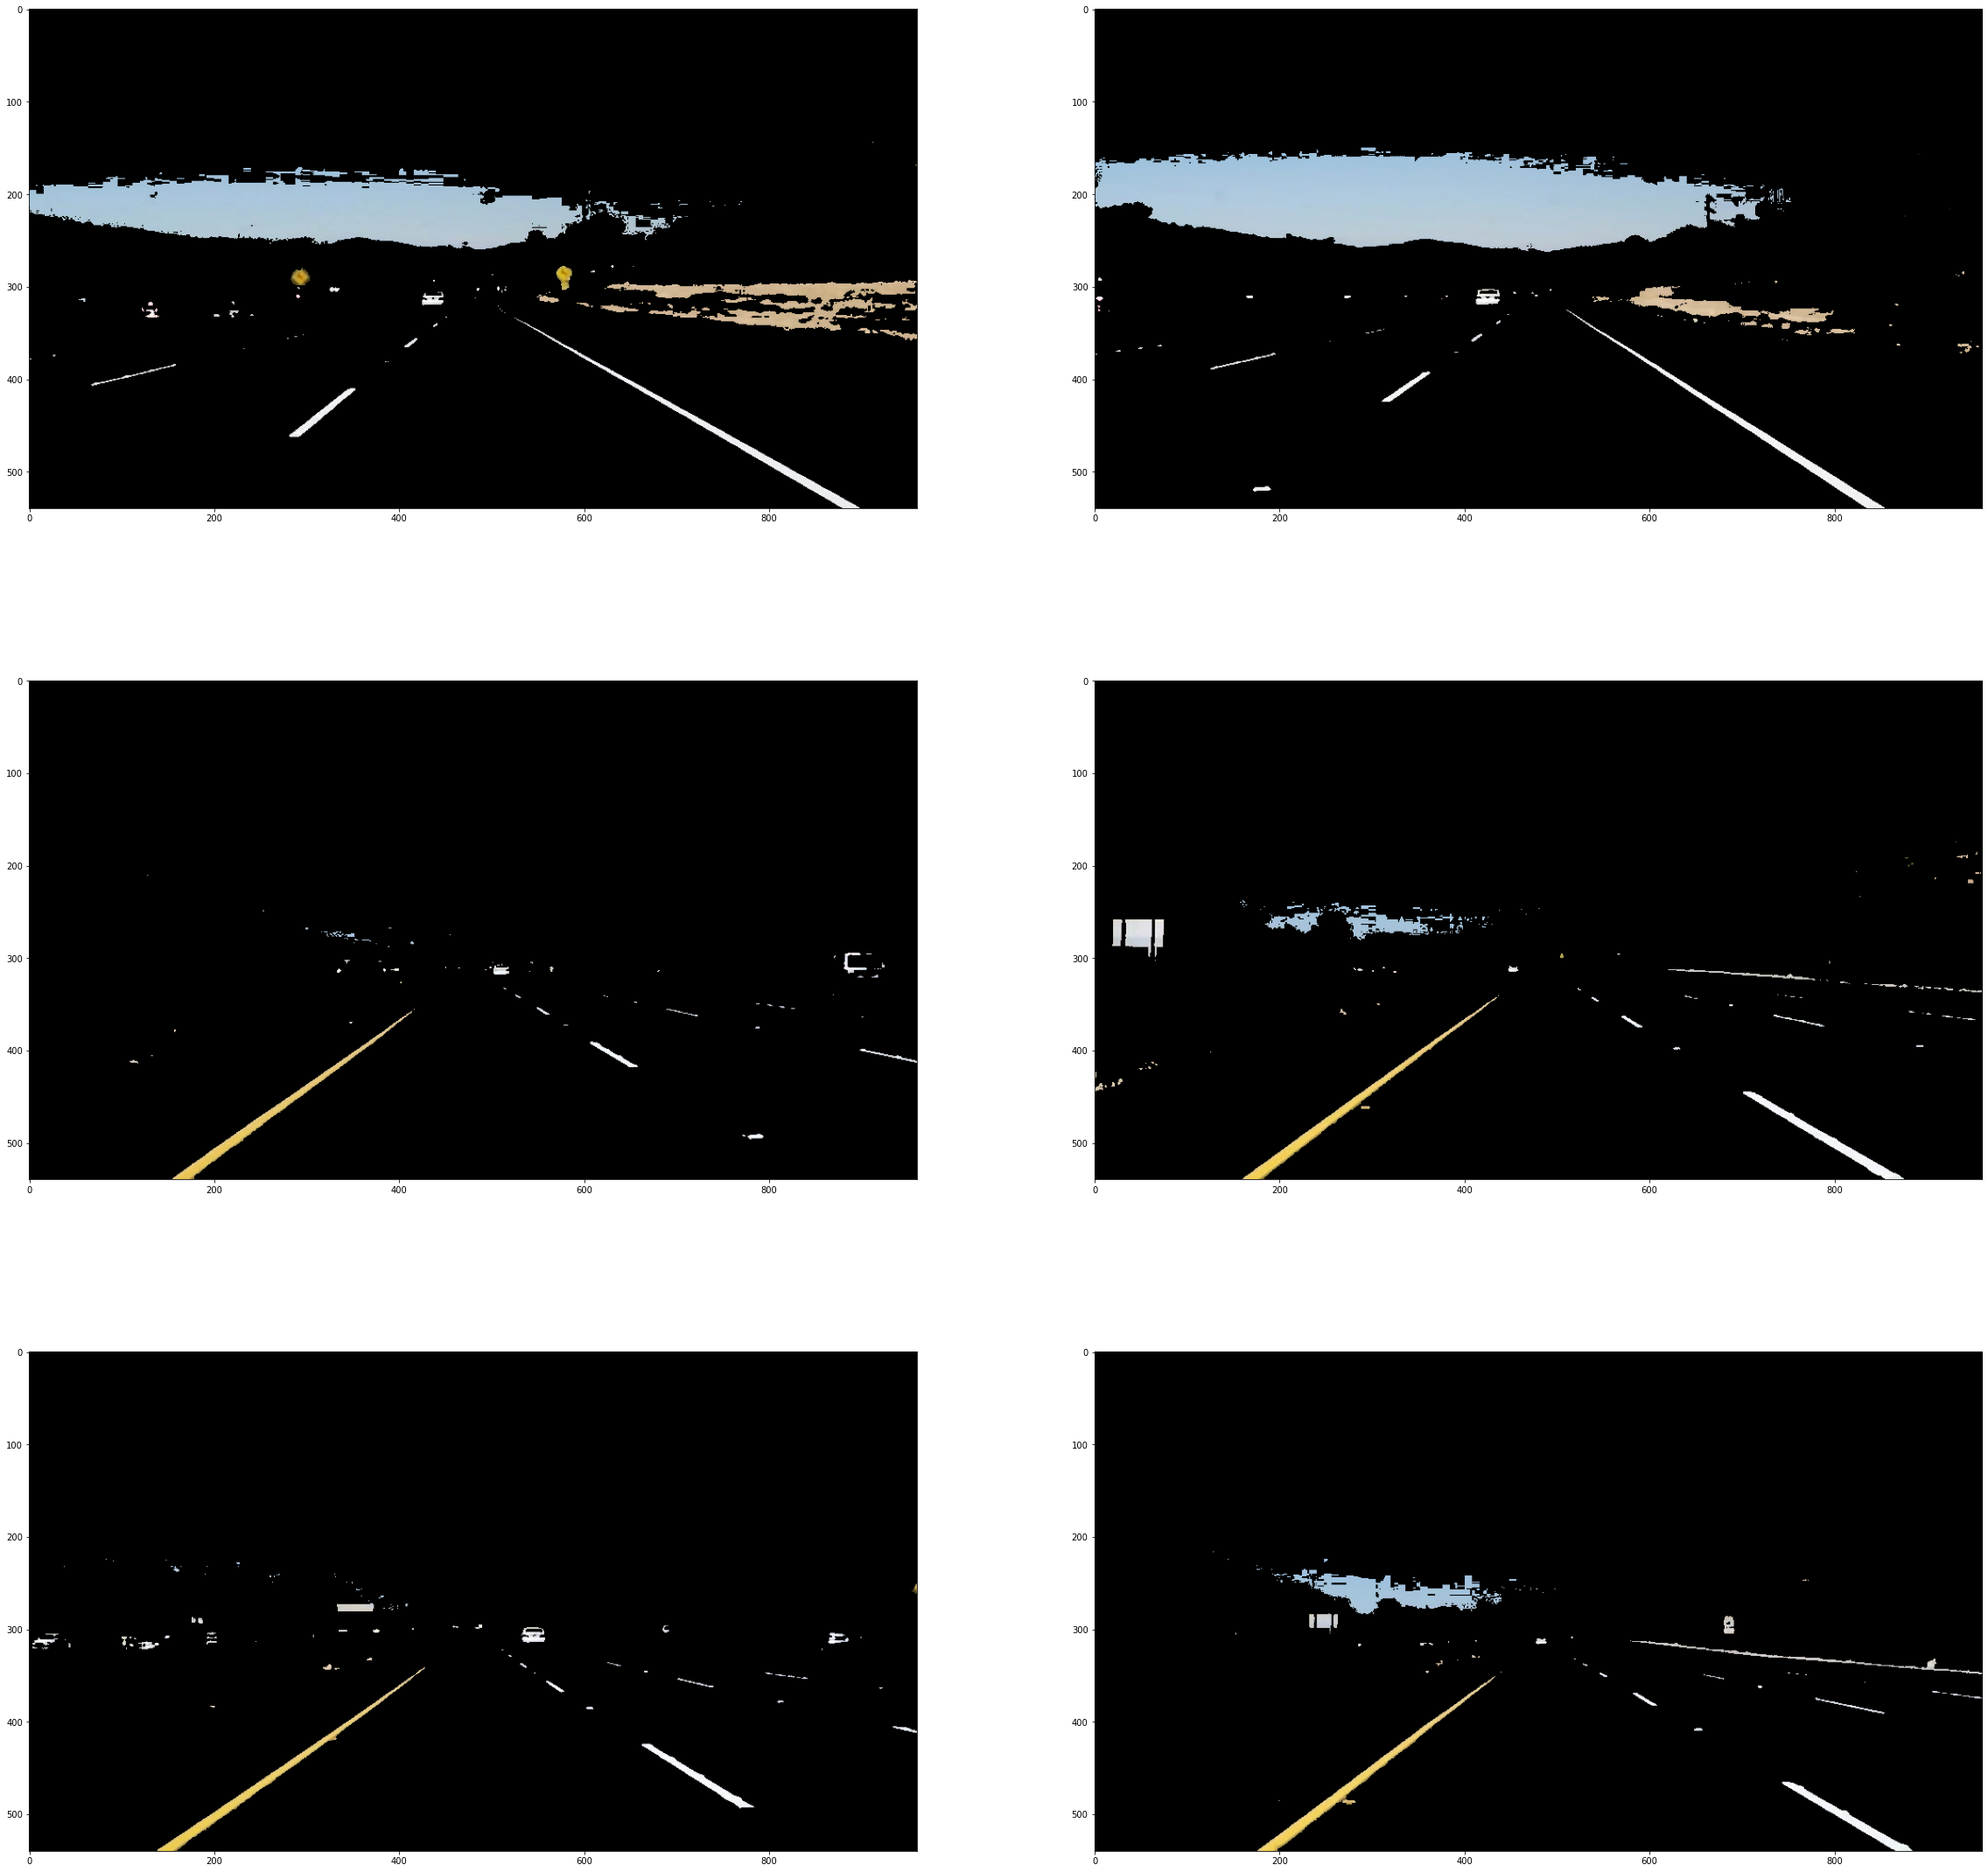

In [9]:
def color_filter(image):
    #convert to HLS to mask based on HLS
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    lower = np.array([0,190,0])
    upper = np.array([255,255,255])
    
    yellower = np.array([10,0,90])
    yelupper = np.array([50,255,255])
    
    yellowmask = cv2.inRange(hls, yellower, yelupper)    
    whitemask = cv2.inRange(hls, lower, upper)
    
    mask = cv2.bitwise_or(yellowmask, whitemask)  
    masked = cv2.bitwise_and(image, image, mask = mask)    
    


    return masked

filtered_img = list(map(color_filter, imageList))

display_images(filtered_img)

# Region of Interest

You might have noticed in the previous operation that we had some parts of the image that weren't lane lines. We need to remove these and isolate the lane lines, and we'll be doing that by masking out everything outside our region of interest, which is represented as a polygon

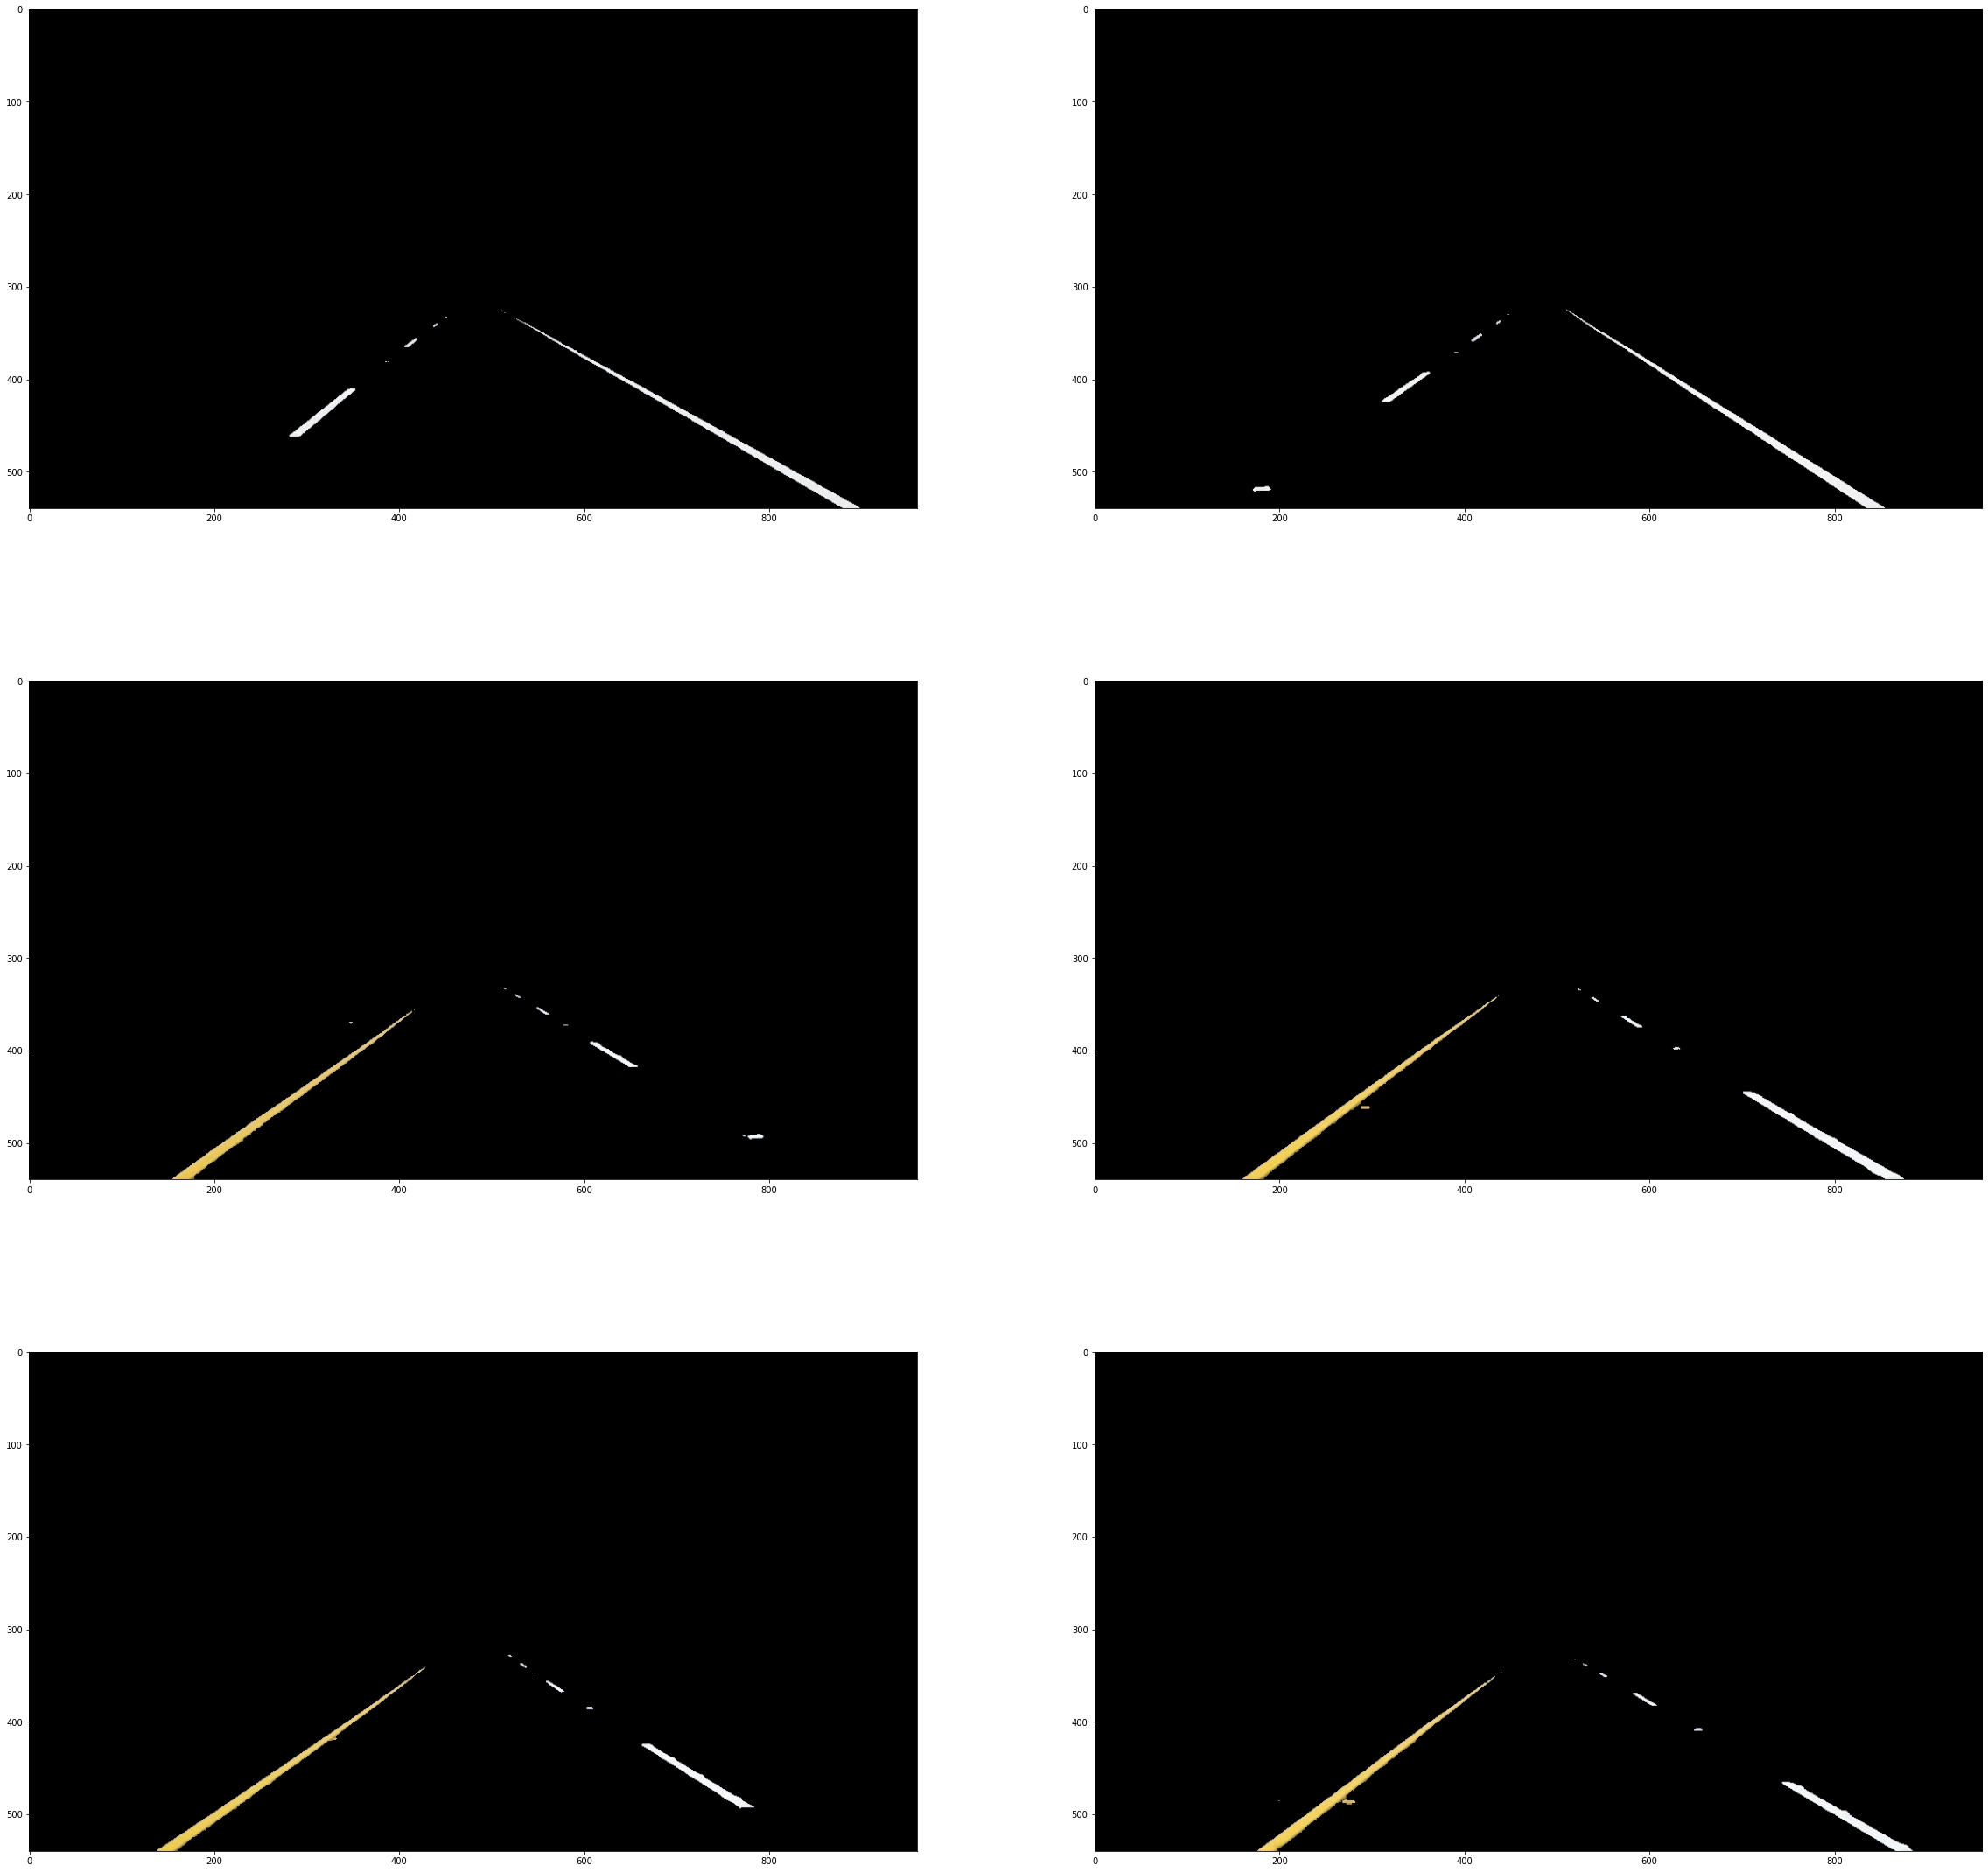

In [10]:
def roi(img):
    x = int(img.shape[1])
    y = int(img.shape[0])
    shape = np.array([[int(0), int(y)], [int(x), int(y)], [int(0.55*x), int(0.6*y)], [int(0.45*x), int(0.6*y)]])

    #define a numpy array with the dimensions of img, but comprised of zeros
    mask = np.zeros_like(img)

    #Uses 3 channels or 1 channel for color depending on input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    #creates a polygon with the mask color
    cv2.fillPoly(mask, np.int32([shape]), ignore_mask_color)

    #returns the image only where the mask pixels are not zero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

roi_img = list(map(roi, filtered_img))

display_images(roi_img)

# Edge Detection

We now have an image in which the lane lines have been isolated. Now we need to compute the edges of the images. We'll be doing this by converting our input image to the "gray" colorspace, then compute the gradient(rate of change) of pixels adjacent to each other. This method of computing edges using gradients is called Canny Edge Detection.

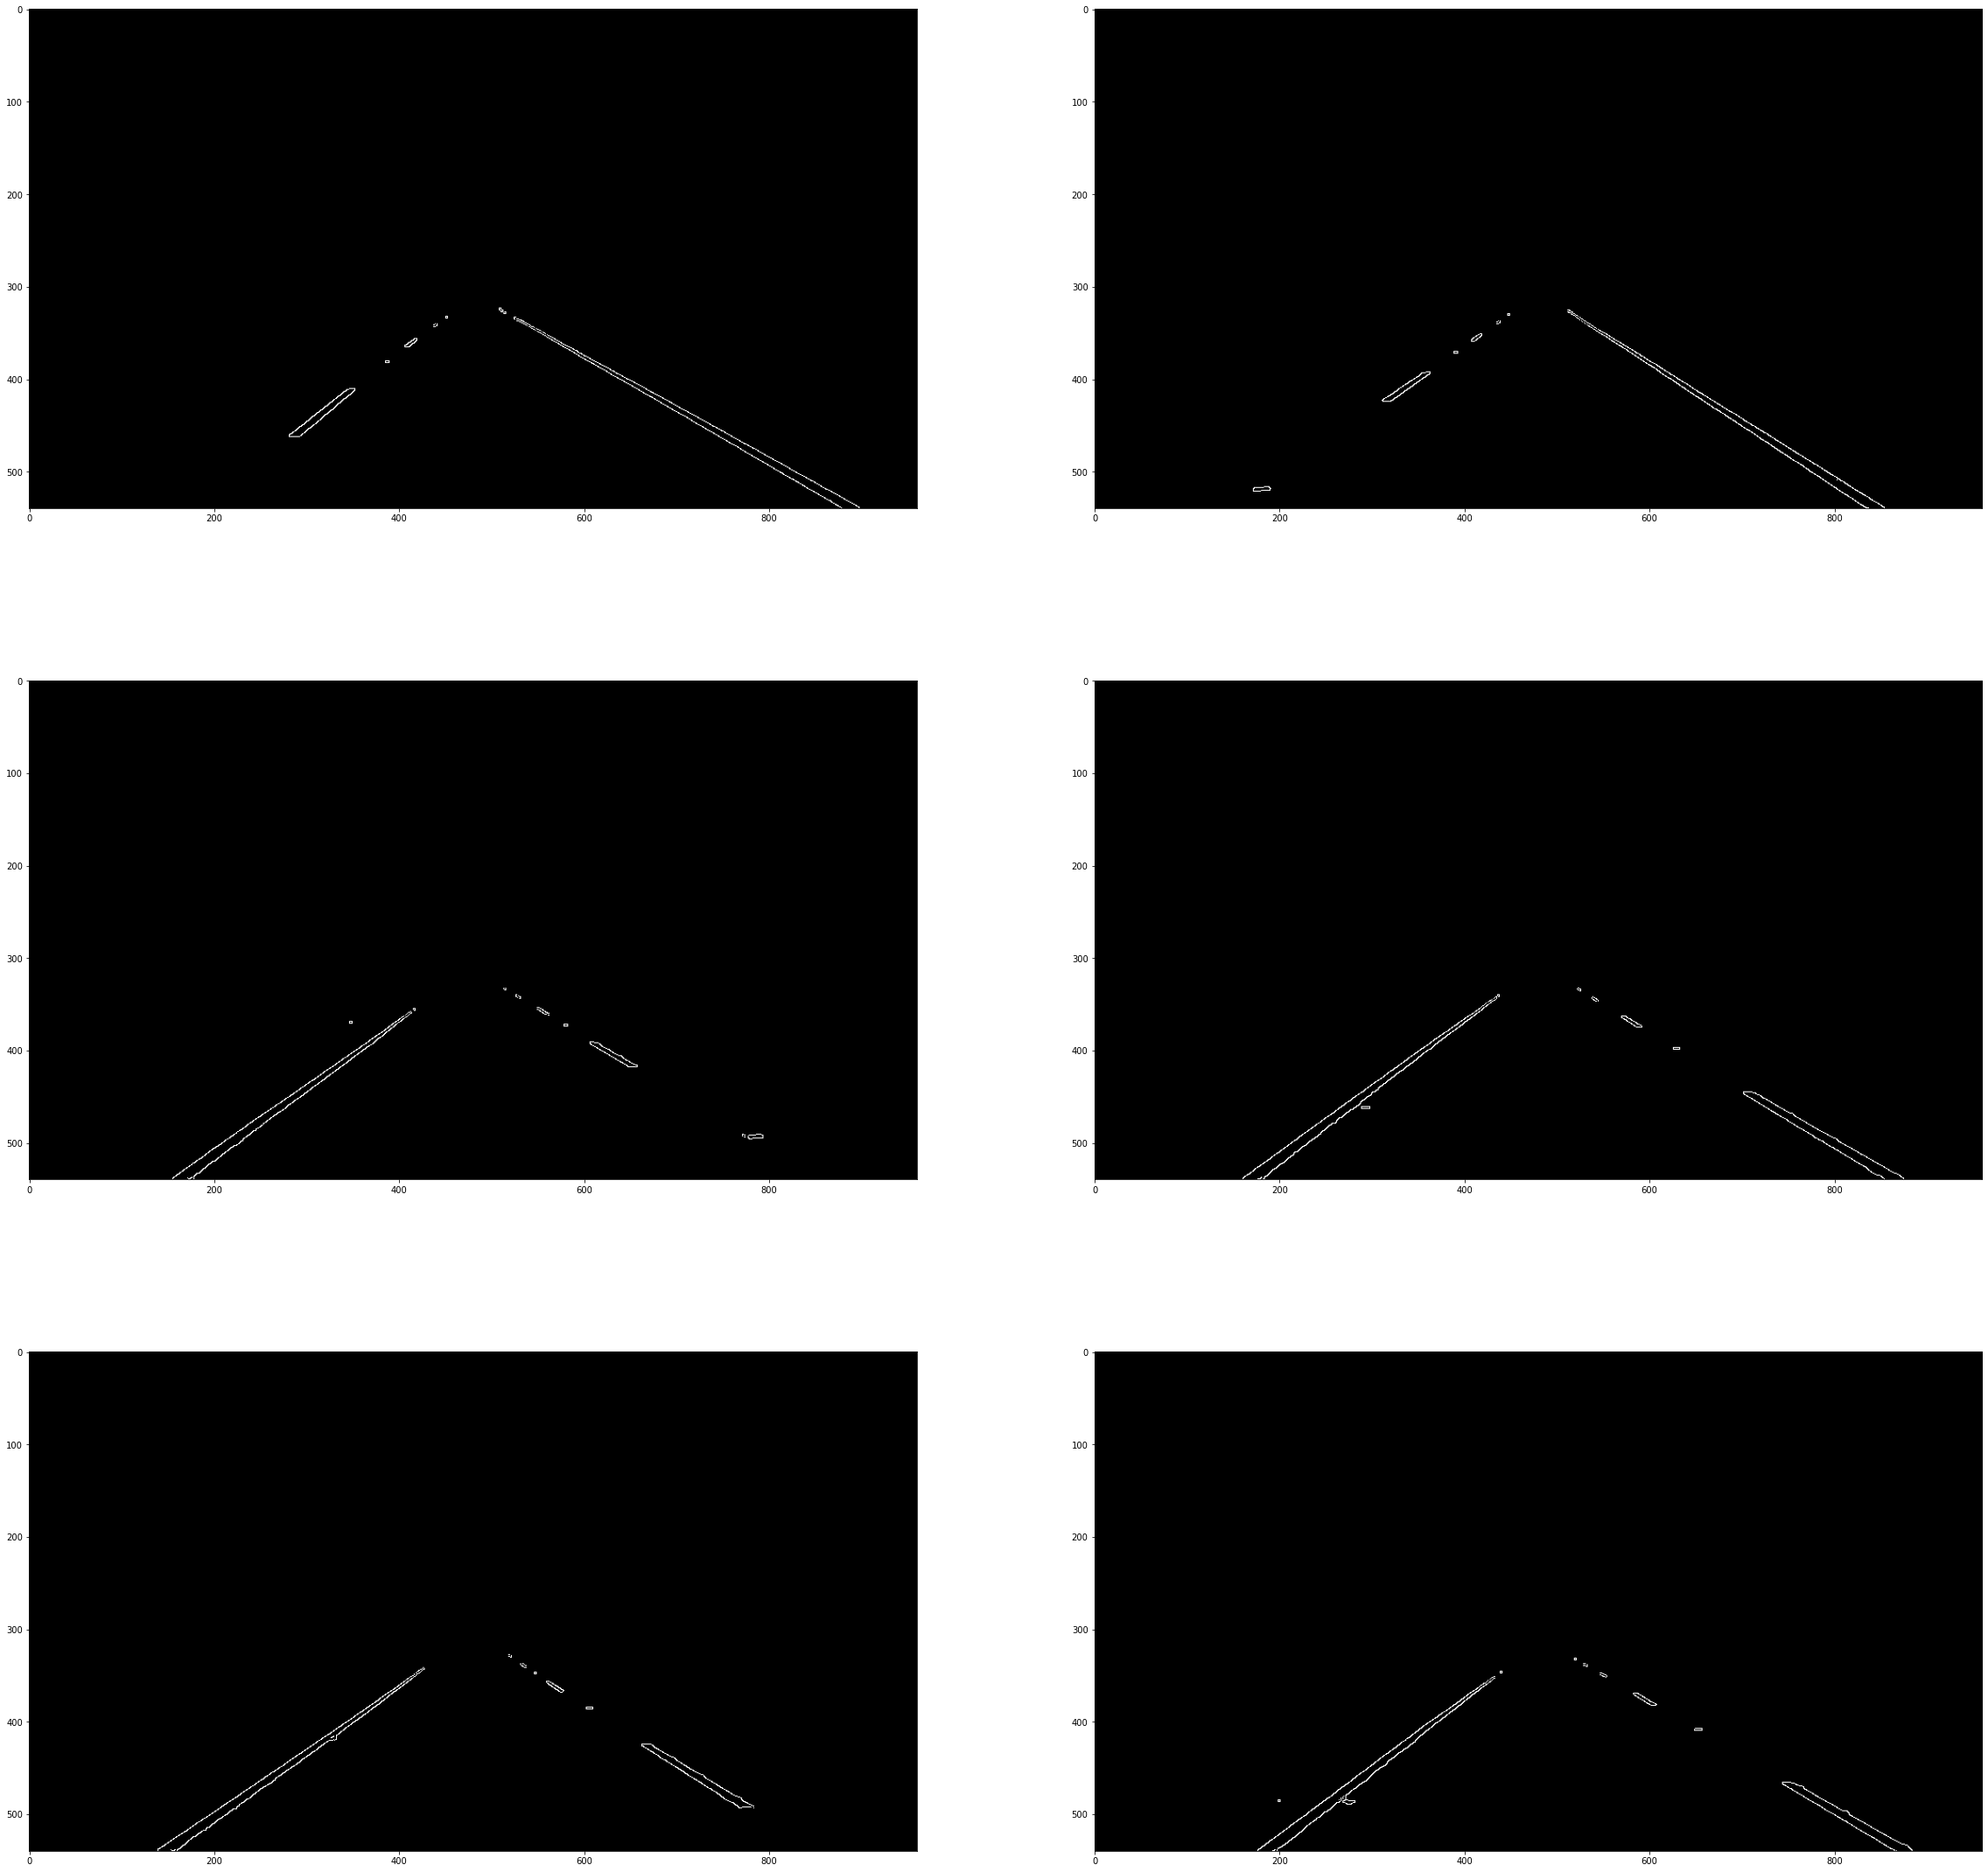

In [11]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def canny(img):
    return cv2.Canny(grayscale(img), 50, 120)

canny_img = list(map(canny, roi_img))
display_images(canny_img,cmap='gray')

# Finding Lanes

This is the hardest part of the project. We need to determine the lane lines from the canny edges we previously detected.

How can you detect lines? We'll be computing the lines using cv2.HoughLinesP(), and then filtering out the lines. We'll start by removing lines that are outside a determined slope range, and zone. Additionally, we will filter the lines into their own corresponding lanes by seeing whether or not the filtered lines have positive or negative slope.

Now we have the lines that correspond to their lane; how do we combine them into a single line? One way to approach it is by using the slope and intercept of the lines. We'll be calculating the slope and intercept of each of the lines in a particular lane, then averaging the slope and intercepts to produce one line. We'll do this to both lanes.

We've detected the lanes somewhat accurately now, but if we were to apply this to a video stream, the lines would oscillate way too much, and is likely to remain unstable. We can make the line more stable by using interframe averaging. Basically, we will be averaging the slope and intercepts of the lane lines from previous frames. This way, the line moves much more slowly and accurately.


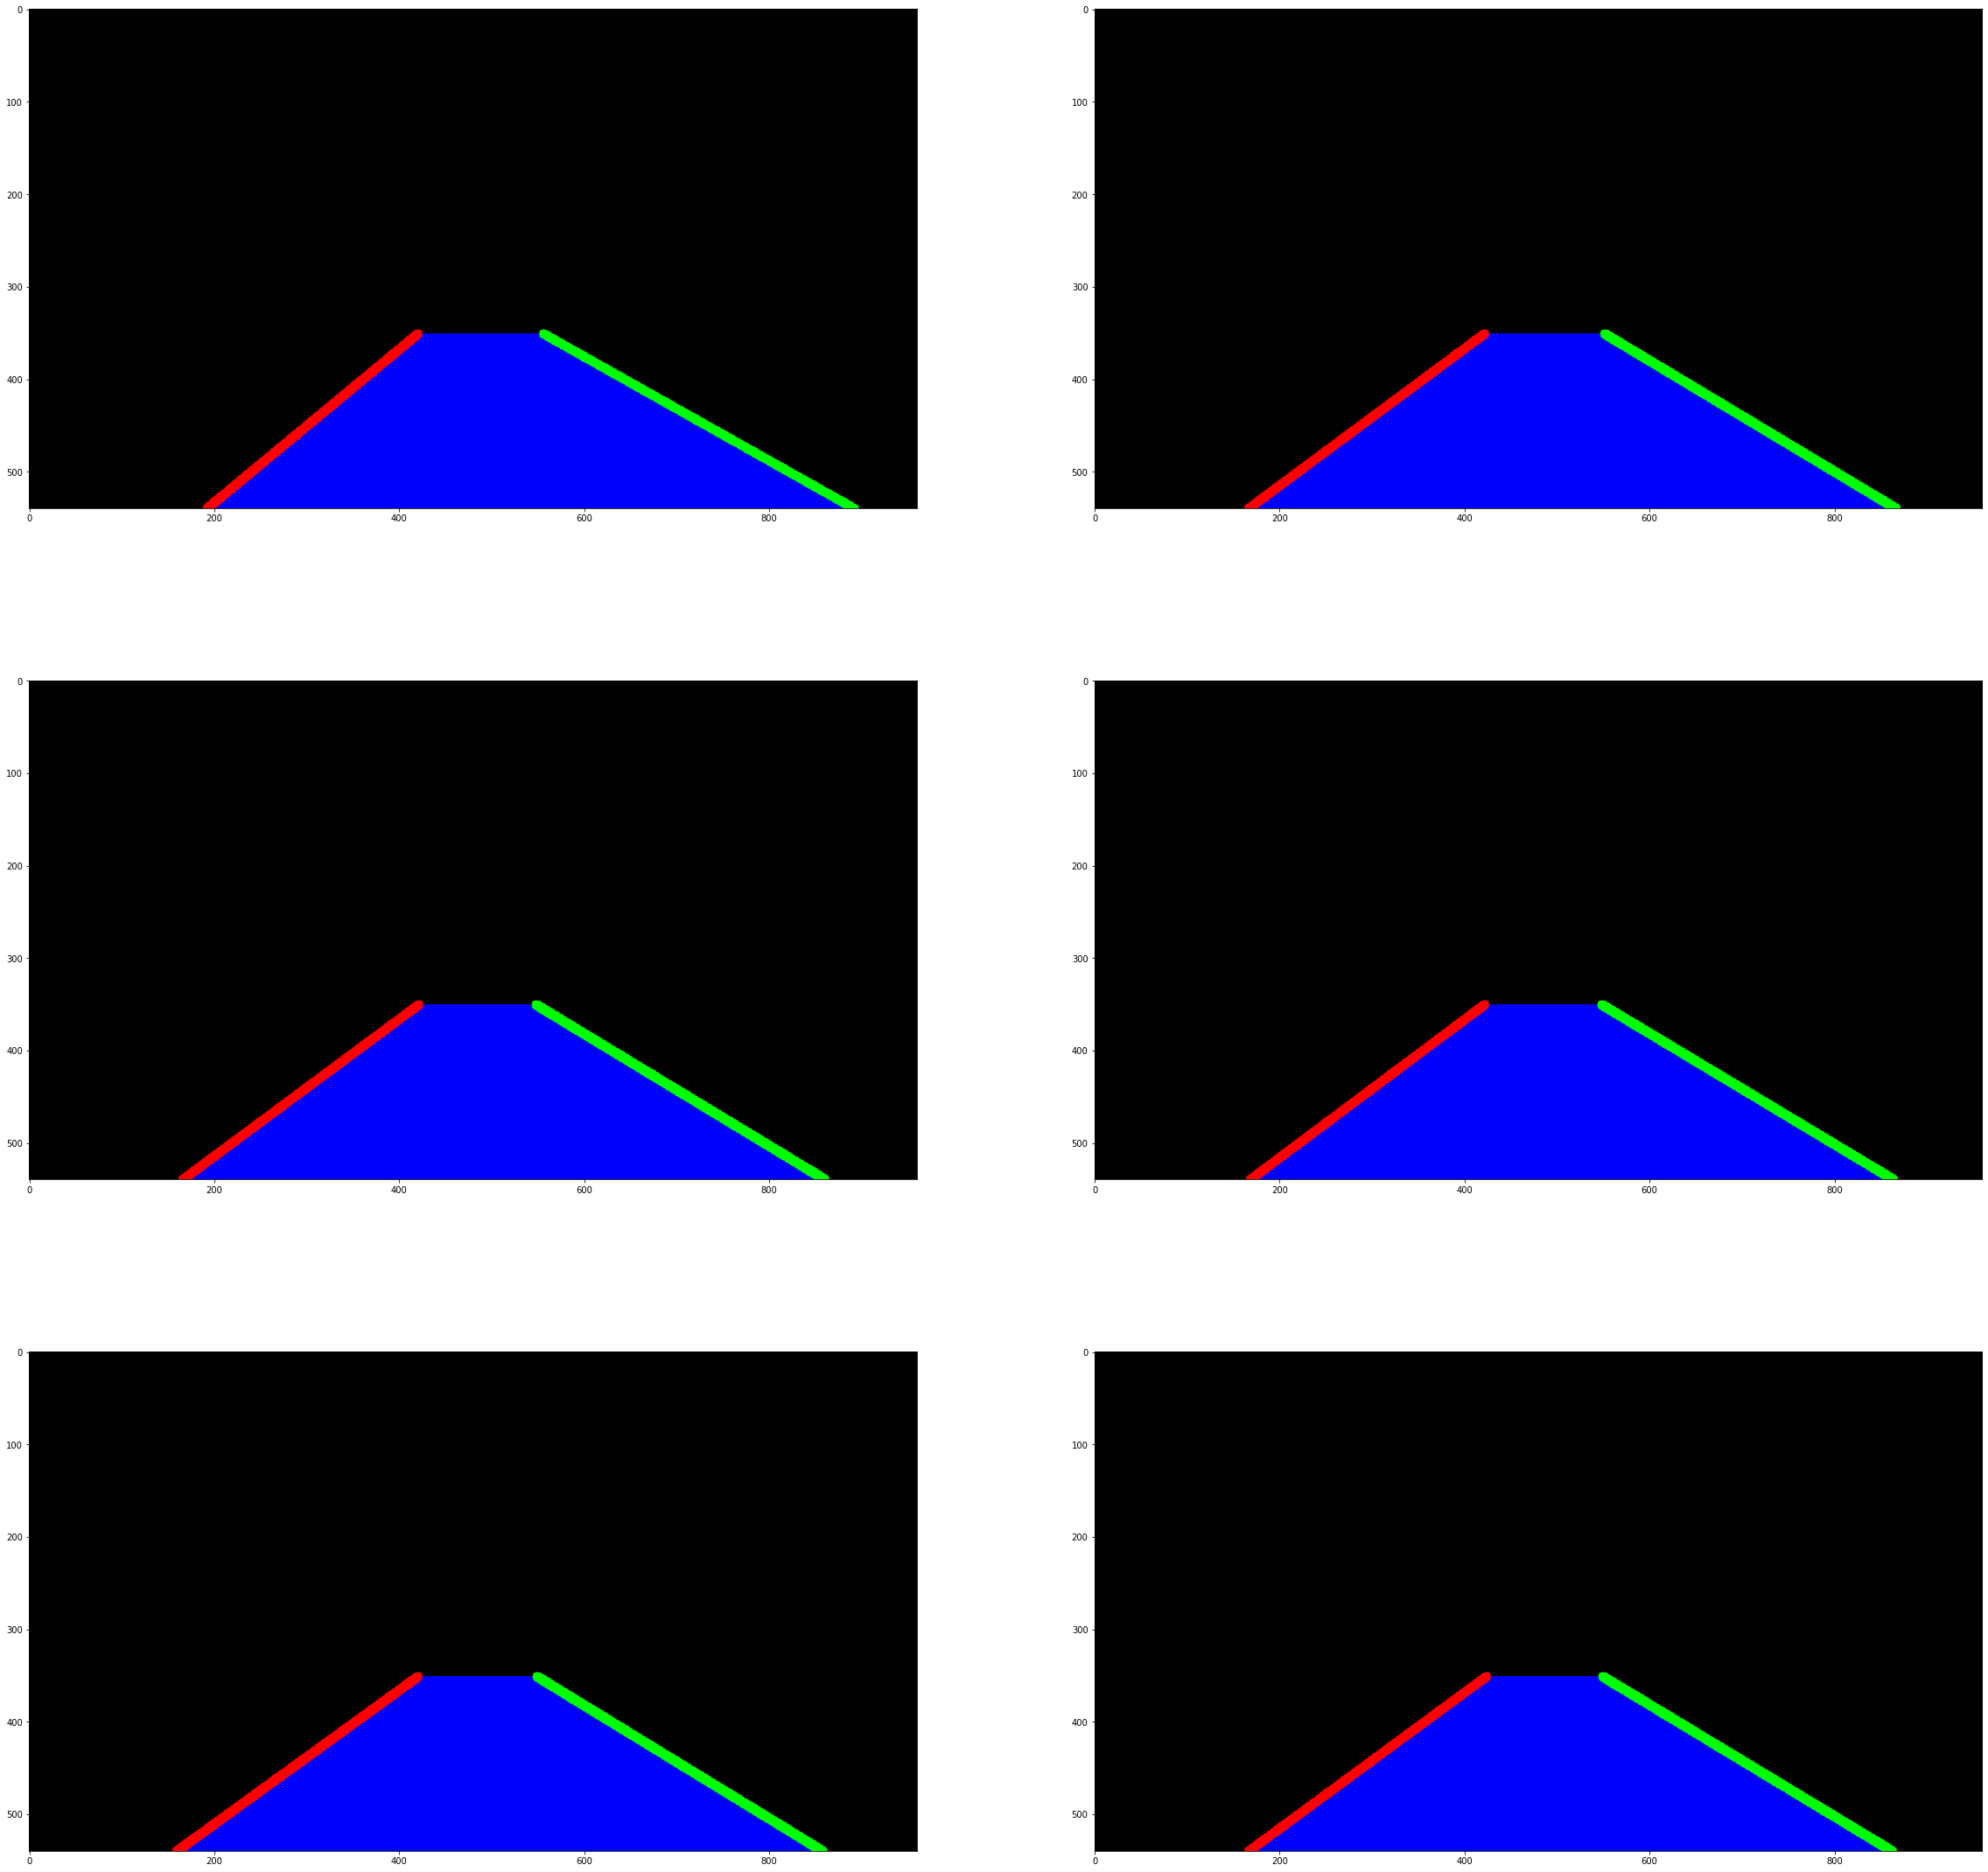

In [12]:
rightSlope, leftSlope, rightIntercept, leftIntercept = [],[],[],[]
def draw_lines(img, lines, thickness=5):
    global rightSlope, leftSlope, rightIntercept, leftIntercept
    rightColor=[0,255,0]
    leftColor=[255,0,0]
    
    #this is used to filter out the outlying lines that can affect the average
    #We then use the slope we determined to find the y-intercept of the filtered lines by solving for b in y=mx+b
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y1-y2)/(x1-x2)
            if slope > 0.3:
                if x1 > 500 :
                    yintercept = y2 - (slope*x2)                    
                    rightSlope.append(slope)
                    rightIntercept.append(yintercept)
                else: None                
            elif slope < -0.3:
                if x1 < 600:
                    yintercept = y2 - (slope*x2)                    
                    leftSlope.append(slope)
                    leftIntercept.append(yintercept)    
                    
                    
    #We use slicing operators and np.mean() to find the averages of the 30 previous frames
    #This makes the lines more stable, and less likely to shift rapidly
    leftavgSlope = np.mean(leftSlope[-30:])
    leftavgIntercept = np.mean(leftIntercept[-30:])
    
    rightavgSlope = np.mean(rightSlope[-30:])
    rightavgIntercept = np.mean(rightIntercept[-30:])
    
    
    #Here we plot the lines and the shape of the lane using the average slope and intercepts
    try:
        left_line_x1 = int((0.65*img.shape[0] - leftavgIntercept)/leftavgSlope)
        left_line_x2 = int((img.shape[0] - leftavgIntercept)/leftavgSlope)
    
        right_line_x1 = int((0.65*img.shape[0] - rightavgIntercept)/rightavgSlope)
        right_line_x2 = int((img.shape[0] - rightavgIntercept)/rightavgSlope)

        pts = np.array([[left_line_x1, int(0.65*img.shape[0])],[left_line_x2, int(img.shape[0])],[right_line_x2, int(img.shape[0])],[right_line_x1, int(0.65*img.shape[0])]], np.int32)
        pts = pts.reshape((-1,1,2))
        cv2.fillPoly(img,[pts],(0,0,255))      
        
        
        cv2.line(img, (left_line_x1, int(0.65*img.shape[0])), (left_line_x2, int(img.shape[0])), leftColor, 10)
        cv2.line(img, (right_line_x1, int(0.65*img.shape[0])), (right_line_x2, int(img.shape[0])), rightColor, 10)
    except ValueError:
            #I keep getting errors for some reason, so I put this here. Idk if the error still persists.
        pass
    
    
    
                
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def linedetect(img):
    return hough_lines(img, 1, np.pi/180, 10, 20, 100)

hough_img = list(map(linedetect, canny_img))
display_images(hough_img)

# Overlaying the Image and the lines

We're close to the end of this project, all we need to do now is just overlay the detected lines and lane onto the input image. We'll be doing this via a weighted sum of the two images.

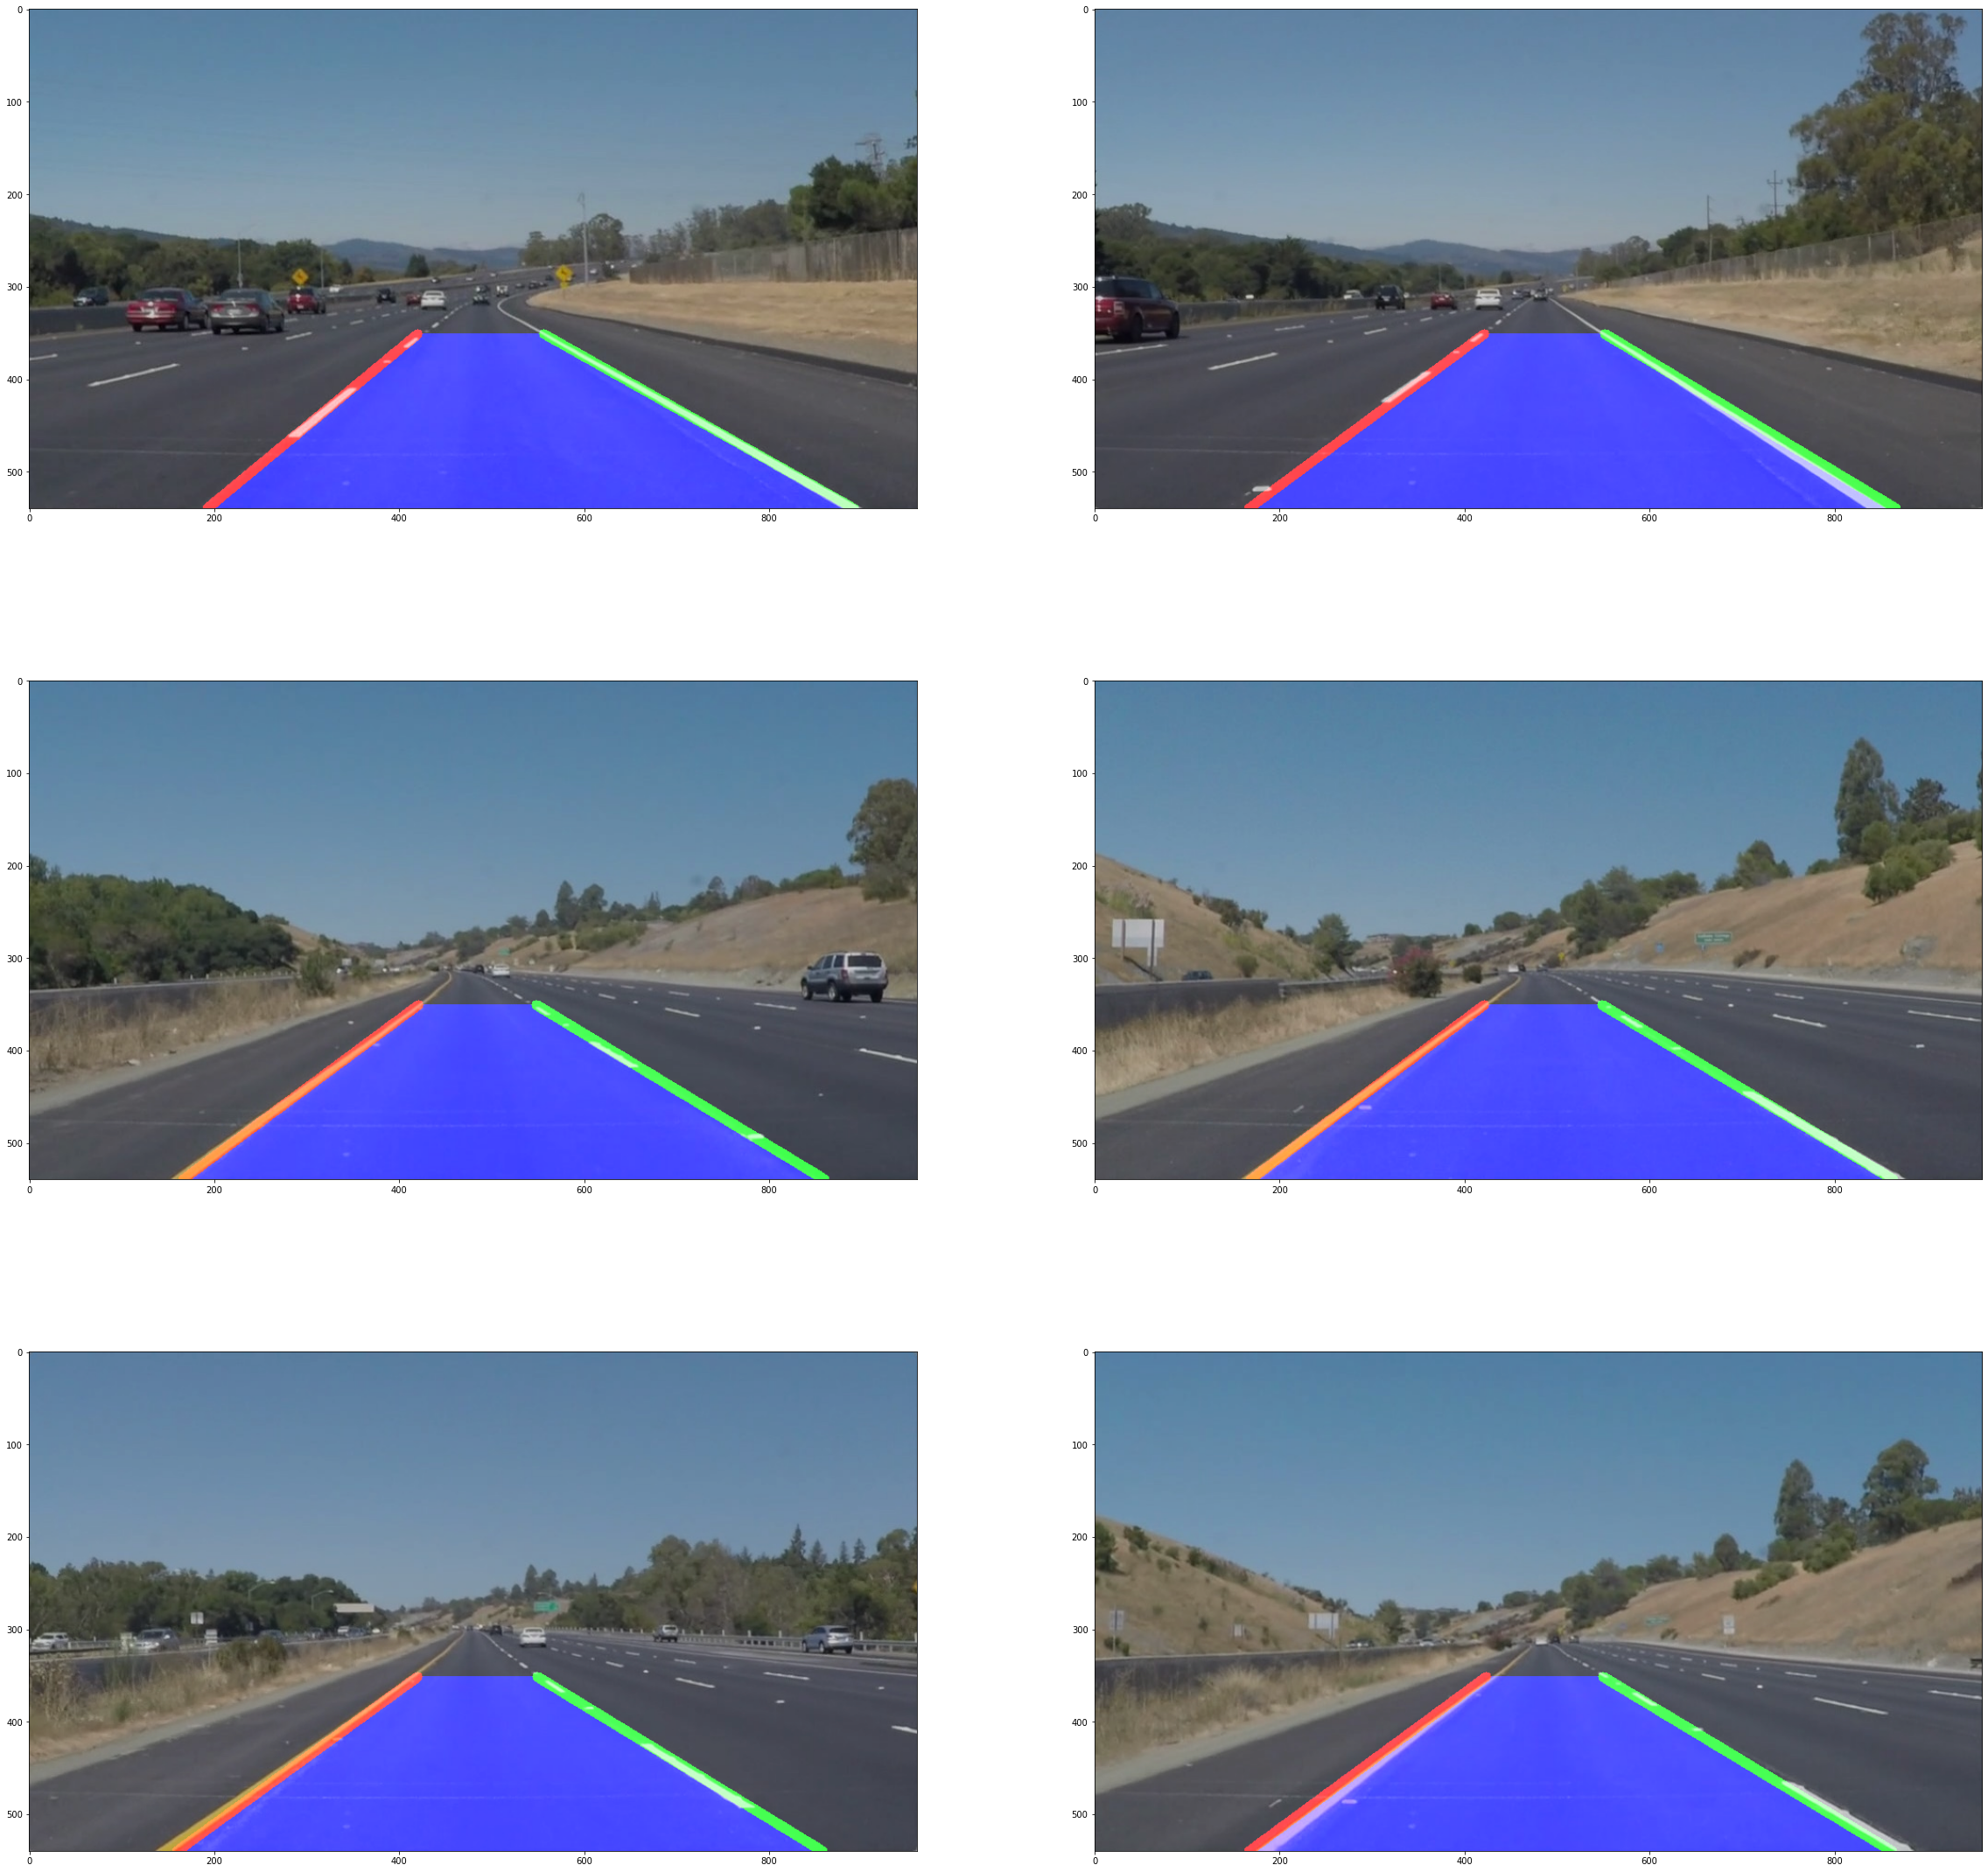

In [13]:
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def weightSum(input_set):
    img = list(input_set)
    return cv2.addWeighted(img[0], 1, img[1], 0.8, 0)

result_img = list(map(weightSum, zip(hough_img, imageList)))
display_images(result_img)

# Applying to the vedio

This project is cool and all, but what good is lane detection without video? We'll be applying the exact same pipeline to our video, then output it.

In [14]:
def processImage(image):
    interest = roi(image)
    filterimg = color_filter(interest)
    canny = cv2.Canny(grayscale(filterimg), 50, 120)
    myline = hough_lines(canny, 1, np.pi/180, 10, 20, 5)
    weighted_img = cv2.addWeighted(myline, 1, image, 0.8, 0)
    
    return weighted_img

In [17]:
#challenge.mp4
#solidWhiteRight.mp4
#solidYellowLeft.mp4

output1 = 'C:/Users/jaysi/Downloads/Lane detection/test_videos_output/solidYellowLeft.mp4'
output2 = 'C:/Users/jaysi/Downloads/Lane detection/test_videos_output/solidWhiteRight.mp4'
output3 = 'C:/Users/jaysi/Downloads/Lane detection/test_videos_output/challenge.mp4'
clip1 = VideoFileClip("test_videos/solidYellowLeft.mp4")#.subclip(3,5)
clip2 = VideoFileClip("test_videos/solidWhiteRight.mp4")#.subclip(3,5)
clip3 = VideoFileClip("test_videos/challenge.mp4")#.subclip(3,5)
pclip1 = clip1.fl_image(processImage) #NOTE: this function expects color images!!
pclip2 = clip2.fl_image(processImage) #NOTE: this function expects color images!!
pclip3 = clip3.fl_image(processImage) #NOTE: this function expects color images!!
%time pclip1.write_videofile(output1, audio=False)
%time pclip2.write_videofile(output2, audio=False)
%time pclip3.write_videofile(output3, audio=False)

                                                                                                                       
                                                                                                                    



                                                                                                           

                                                                                                                 


                                                                                                              




t:   1%|▌                                                                    | 2/221 [06:16<00:28,  7.71it/s, now=None]



t:   1%|▌                                                                    | 2/221 [01:52<00:27,  8.08it/s, now=None]

t:   1%|▌                                                                    | 2/251 [06:15<00:33,  7.43it/s, now=None]


t:   0%|▏                                             

Moviepy - Building video C:/Users/jaysi/Downloads/Lane detection/test_videos/solidYellowLeft.mp4.
Moviepy - Writing video C:/Users/jaysi/Downloads/Lane detection/test_videos/solidYellowLeft.mp4









t:   0%|▏                                                                    | 2/681 [00:00<01:25,  7.99it/s, now=None]





t:   1%|▍                                                                    | 4/681 [00:00<00:57, 11.81it/s, now=None]





t:   1%|▋                                                                    | 7/681 [00:00<00:42, 15.77it/s, now=None]





t:   1%|▉                                                                    | 9/681 [00:00<00:40, 16.73it/s, now=None]





t:   2%|█▏                                                                  | 12/681 [00:00<00:36, 18.53it/s, now=None]





t:   2%|█▍                                                                  | 15/681 [00:00<00:33, 19.69it/s, now=None]





t:   3%|█▊                                                                  | 18/681 [00:01<00:32, 20.24it/s, now=None]





t:   3%|██                                                                  | 21/681 [00:01<00:30, 21.89it/s, now=None]

t:  25%|████████████████▊                                                  | 171/681 [00:07<00:22, 22.63it/s, now=None]





t:  26%|█████████████████                                                  | 174/681 [00:07<00:22, 22.13it/s, now=None]





t:  26%|█████████████████▍                                                 | 177/681 [00:07<00:22, 21.97it/s, now=None]





t:  26%|█████████████████▋                                                 | 180/681 [00:07<00:22, 21.93it/s, now=None]





t:  27%|██████████████████                                                 | 183/681 [00:07<00:21, 23.05it/s, now=None]





t:  27%|██████████████████▎                                                | 186/681 [00:08<00:20, 23.67it/s, now=None]





t:  28%|██████████████████▌                                                | 189/681 [00:08<00:20, 23.68it/s, now=None]





t:  28%|██████████████████▉                                                | 192/681 [00:08<00:21, 22.75it/s, now=None]







t:  51%|██████████████████████████████████▏                                | 348/681 [00:14<00:13, 24.43it/s, now=None]





t:  52%|██████████████████████████████████▌                                | 351/681 [00:14<00:13, 24.50it/s, now=None]





t:  52%|██████████████████████████████████▊                                | 354/681 [00:14<00:13, 24.61it/s, now=None]





t:  52%|███████████████████████████████████                                | 357/681 [00:14<00:13, 24.62it/s, now=None]





t:  53%|███████████████████████████████████▍                               | 360/681 [00:15<00:12, 25.38it/s, now=None]





t:  53%|███████████████████████████████████▋                               | 363/681 [00:15<00:12, 25.54it/s, now=None]





t:  54%|████████████████████████████████████                               | 366/681 [00:15<00:12, 25.85it/s, now=None]





t:  54%|████████████████████████████████████▎                              | 369/681 [00:15<00:12, 25.81it/s, now=None]







t:  76%|███████████████████████████████████████████████████                | 519/681 [00:21<00:06, 25.24it/s, now=None]





t:  77%|███████████████████████████████████████████████████▎               | 522/681 [00:21<00:06, 24.94it/s, now=None]





t:  77%|███████████████████████████████████████████████████▋               | 525/681 [00:21<00:06, 24.67it/s, now=None]





t:  78%|███████████████████████████████████████████████████▉               | 528/681 [00:21<00:06, 25.10it/s, now=None]





t:  78%|████████████████████████████████████████████████████▏              | 531/681 [00:21<00:06, 24.78it/s, now=None]





t:  78%|████████████████████████████████████████████████████▌              | 534/681 [00:22<00:05, 24.87it/s, now=None]





t:  79%|████████████████████████████████████████████████████▊              | 537/681 [00:22<00:05, 26.09it/s, now=None]





t:  79%|█████████████████████████████████████████████████████▏             | 540/681 [00:22<00:05, 25.77it/s, now=None]







                                                                                                                 


                                                                                                              




t:   1%|▌                                                                    | 2/221 [06:44<00:28,  7.71it/s, now=None]



t:   1%|▌                                                                    | 2/221 [02:21<00:27,  8.08it/s, now=None]

t:   1%|▌                                                                    | 2/251 [06:44<00:33,  7.43it/s, now=None]


t:   0%|▏                                                                    | 2/681 [02:21<01:12,  9.37it/s, now=None]




                                                                                                                       
                                                                                                                    



                                       

Moviepy - Done !
Moviepy - video ready C:/Users/jaysi/Downloads/Lane detection/test_videos/solidYellowLeft.mp4
Wall time: 28.7 s





                                                                                                              




t:   1%|▌                                                                    | 2/221 [06:44<00:28,  7.71it/s, now=None]



t:   1%|▌                                                                    | 2/221 [02:21<00:27,  8.08it/s, now=None]

t:   1%|▌                                                                    | 2/251 [06:44<00:33,  7.43it/s, now=None]


t:   0%|▏                                                                    | 2/681 [02:22<01:12,  9.37it/s, now=None]




                                                                                                                       
                                                                                                                    



                                                                                                           

                                           

Moviepy - Building video C:/Users/jaysi/Downloads/Lane detection/test_videos/solidWhiteRight.mp4.
Moviepy - Writing video C:/Users/jaysi/Downloads/Lane detection/test_videos/solidWhiteRight.mp4









t:   1%|▌                                                                    | 2/221 [00:00<00:30,  7.11it/s, now=None]





t:   2%|█▏                                                                   | 4/221 [00:00<00:19, 11.09it/s, now=None]





t:   3%|██▏                                                                  | 7/221 [00:00<00:13, 15.32it/s, now=None]





t:   5%|███                                                                 | 10/221 [00:00<00:12, 17.33it/s, now=None]





t:   6%|████                                                                | 13/221 [00:00<00:10, 19.01it/s, now=None]





t:   7%|████▉                                                               | 16/221 [00:00<00:10, 20.35it/s, now=None]





t:   9%|█████▊                                                              | 19/221 [00:01<00:09, 22.11it/s, now=None]





t:  10%|██████▊                                                             | 22/221 [00:01<00:08, 23.16it/s, now=None]

t:  79%|█████████████████████████████████████████████████████              | 175/221 [00:07<00:01, 24.67it/s, now=None]





t:  81%|█████████████████████████████████████████████████████▉             | 178/221 [00:07<00:01, 25.81it/s, now=None]





t:  82%|███████████████████████████████████████████████████████▏           | 182/221 [00:07<00:01, 27.65it/s, now=None]





t:  84%|████████████████████████████████████████████████████████           | 185/221 [00:07<00:01, 26.94it/s, now=None]





t:  85%|████████████████████████████████████████████████████████▉          | 188/221 [00:07<00:01, 27.13it/s, now=None]





t:  86%|█████████████████████████████████████████████████████████▉         | 191/221 [00:07<00:01, 26.90it/s, now=None]





t:  88%|██████████████████████████████████████████████████████████▊        | 194/221 [00:07<00:01, 25.30it/s, now=None]





t:  89%|███████████████████████████████████████████████████████████▋       | 197/221 [00:08<00:00, 25.23it/s, now=None]







Moviepy - Done !
Moviepy - video ready C:/Users/jaysi/Downloads/Lane detection/test_videos/solidWhiteRight.mp4
Wall time: 9.79 s
Moviepy - Building video C:/Users/jaysi/Downloads/Lane detection/test_videos/challenge.mp4.







                                                                                                                       
                                                                                                                    



                                                                                                           

                                                                                                                 


                                                                                                              




t:   1%|▌                                                                    | 2/221 [06:54<00:28,  7.71it/s, now=None]



t:   1%|▌                                                                    | 2/221 [02:31<00:27,  8.08it/s, now=None]

t:   1%|▌                                                                    | 2/251 [06:54<00:33,  7.43it/s, now=None]


t:   0%|▏                                        

Moviepy - Writing video C:/Users/jaysi/Downloads/Lane detection/test_videos/challenge.mp4









t:   1%|▌                                                                    | 2/251 [00:00<00:35,  7.06it/s, now=None]





t:   2%|█                                                                    | 4/251 [00:00<00:25,  9.55it/s, now=None]





t:   2%|█▋                                                                   | 6/251 [00:00<00:22, 10.99it/s, now=None]





t:   3%|██▏                                                                  | 8/251 [00:00<00:20, 11.93it/s, now=None]





t:   4%|██▋                                                                 | 10/251 [00:00<00:19, 12.17it/s, now=None]





t:   5%|███▎                                                                | 12/251 [00:01<00:18, 12.63it/s, now=None]





t:   6%|███▊                                                                | 14/251 [00:01<00:18, 12.89it/s, now=None]





t:   6%|████▎                                                               | 16/251 [00:01<00:17, 13.12it/s, now=None]

t:  46%|██████████████████████████████▉                                    | 116/251 [00:07<00:07, 16.92it/s, now=None]





t:  47%|███████████████████████████████▍                                   | 118/251 [00:07<00:08, 16.49it/s, now=None]





t:  48%|████████████████████████████████                                   | 120/251 [00:07<00:07, 16.44it/s, now=None]





t:  49%|████████████████████████████████▌                                  | 122/251 [00:08<00:07, 16.38it/s, now=None]





t:  49%|█████████████████████████████████                                  | 124/251 [00:08<00:08, 15.75it/s, now=None]





t:  50%|█████████████████████████████████▋                                 | 126/251 [00:08<00:07, 16.02it/s, now=None]





t:  51%|██████████████████████████████████▏                                | 128/251 [00:08<00:08, 15.26it/s, now=None]





t:  52%|██████████████████████████████████▋                                | 130/251 [00:08<00:07, 15.71it/s, now=None]







t:  92%|█████████████████████████████████████████████████████████████▋     | 231/251 [00:14<00:01, 16.00it/s, now=None]





t:  93%|██████████████████████████████████████████████████████████████▏    | 233/251 [00:14<00:01, 15.71it/s, now=None]





t:  94%|██████████████████████████████████████████████████████████████▋    | 235/251 [00:15<00:01, 15.82it/s, now=None]





t:  94%|███████████████████████████████████████████████████████████████▎   | 237/251 [00:15<00:00, 16.02it/s, now=None]





t:  95%|███████████████████████████████████████████████████████████████▊   | 239/251 [00:15<00:00, 16.15it/s, now=None]





t:  96%|████████████████████████████████████████████████████████████████▎  | 241/251 [00:15<00:00, 15.89it/s, now=None]





t:  97%|████████████████████████████████████████████████████████████████▊  | 243/251 [00:15<00:00, 16.36it/s, now=None]





t:  98%|█████████████████████████████████████████████████████████████████▍ | 245/251 [00:15<00:00, 16.96it/s, now=None]







Moviepy - Done !
Moviepy - video ready C:/Users/jaysi/Downloads/Lane detection/test_videos/challenge.mp4
Wall time: 17 s


In [18]:
HTML("""
<h1>solidYellowLeft.mp4</h1><video width="960" height="540" controls>
<source src="{0}">
</video>
""".format(output1))